In [106]:
#Hedging our bets muni-style

In [107]:
#import statements for packages/libraries
#which libraries do we need?
#pyfolio
#scipy
#backtester

import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.express as px
import hvplot.pandas
from dotenv import load_dotenv
import panel as pn
from panel.interact import interact
from panel import widgets
import alpaca_trade_api as tradeapi
import quandl
import os
import requests

In [108]:
#pull in data from API (7-ish years of data 1/1/2013-11/01/2020)
#bonds--bloomberg
#muni etf (MUB)--alpaca
#swap--bloomberg or alpaca
#treasury--quandl
#treasury ETF (TLT)--alpaca

In [109]:
load_dotenv()

True

In [110]:
#import

api_key_QD = os.getenv("QUANDL_API_KEY")
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# type(api_key_QD)
# type(alpaca_api_key)

In [111]:
#import alpaca api file for ETF price history
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Format current date as ISO format
start_date = pd.Timestamp("2013-01-02", tz="America/New_York").isoformat()
today = pd.Timestamp("2020-11-02", tz="America/New_York").isoformat()

# Set the tickers
tickers = ["MUB", "TLT", "UDN", "UUP","LQD","JNK"]

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get closing prices
df_ETFs = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = today
).df

# Preview DataFrame
# YOUR CODE HERE!
df_ETFs.head()

# Output the data to CSV
df_ETFs.to_csv("Resources/ETFs1.csv", encoding='utf-8', index=True)

In [112]:
ETF_csv = Path("Resources/ETFs.csv")
ETF_df = pd.read_csv(ETF_csv, index_col='Unnamed: 0', infer_datetime_format=True, parse_dates=True)
#ETF_df.rename(columns={'Unnamed: 0': 'Date'}, inplace = True)
ETF_df = ETF_df.drop(ETF_df.index[0])
#ETF_df['Date'] = pd.to_datetime(ETF_df['Date'], utc=True)
ETF_df.index = pd.to_datetime(ETF_df.index, utc=True).date
#ETF_df['Date']= ETF_df['Date'].dt.strftime('%m/%d/%Y')
ETF_df.sort_index(inplace=True)

#drop unneccessary columns and keep close price columns
ETF_close_prices_df = ETF_df.loc[:, ['JNK.3', 'LQD.3', 'MUB.3', 'TLT.3', 'UDN.3', 'UUP.3']]
ETF_close_prices_df.rename(columns={'JNK.3': 'JNK',
                   'LQD.3': 'LQD',
                   'MUB.3': 'MUB',
                   'TLT.3': 'TLT',
                   'UDN.3': 'UDN',
                   'UUP.3': 'UUP',
                  }, inplace=True)

ETF_close_prices_df[['JNK', 'LQD', 'MUB', 'TLT', 'UDN', 'UUP']] = ETF_close_prices_df[['JNK', 'LQD', 'MUB', 'TLT', 'UDN', 'UUP']].astype(float)
ETF_close_prices_df.dtypes

#calculate daily returns
ETF_daily_returns_df = ETF_close_prices_df.pct_change().dropna()
ETF_daily_returns_df.head()

,JNK,LQD,MUB,TLT,UDN,UUP
2013-01-03,-0.002194,-0.005525,0.000002,-0.013632,-0.008094,0.007791
2013-01-04,0.001221,-0.000415,-0.001968,0.003900,-0.000371,0.000000
2013-01-07,0.002196,0.001410,0.001434,0.000210,0.003340,-0.002729
2013-01-08,-0.000487,0.001077,0.001790,0.006714,-0.001294,0.000912
2013-01-09,0.000974,-0.000153,0.002501,-0.001007,-0.003148,0.002733


In [113]:
#import quandl api file for US Treasury Rate history
USTREASURY_data = quandl.get('USTREASURY/YIELD', start_date='2013-01-01', end_date='2020-11-06',authtoken=api_key_QD)
#USTREASURY_data.to_csv('Resources/USTREASURY1.csv', encoding='utf-8', index=True)
USTREASURY_data.head()
columns_to_drop = ['1 MO', '2 MO', '3 MO', '6 MO']
USTREASURY_data.drop(columns=columns_to_drop, inplace=True)
USTREASURY_data.sort_index(inplace=True)

#create new dataframe with maturity values
columns = []
tsy_mty_df = USTREASURY_data.copy()
for column in USTREASURY_data.columns:
    maturity = ''
    for item in column.split():
        if item.isdigit():
            maturity = maturity + item
    #print(int(maturity[0]))
    tsy_mty_df[column] = int(maturity)
    columns.append(maturity)
USTREASURY_data.columns = columns
tsy_mty_df.columns = columns

#USTREASURY_data.head()
#tsy_mty_df.head()

#define function for calculating Treasury bond prices
def bondprice(fv, c, ytm, t, m):
    bondprice = ((fv*c/m*(1-(1+ytm/m)**(-m*t)))/(ytm/m)) + fv*(1+(ytm/m))**(-m*t)
    return(bondprice)

#bondprice(1000,0.06,0.08,9,2)
#bondprice(100,0.0015,0.0014,1,2)

#create new dataframe with treasury bond prices
fv = 100
c = USTREASURY_data.shift(1)/100
ytm = USTREASURY_data/100
m = 2
t = tsy_mty_df
USTREASURY_daily_prices = bondprice(fv, c, ytm, t, m)

USTREASURY_data_daily_returns = USTREASURY_daily_prices.pct_change().dropna()
#USTREASURY_data_daily_returns.head()
USTREASURY_data_daily_returns.columns = USTREASURY_data_daily_returns.columns.astype(int)
USTREASURY_data_daily_returns.head()
#tsy_mty_df.head()

,1,2,3,5,7,10,20,30
Date,,,,,,,,
2013-01-04,0.000000e+00,0.000000,0.000596,0.001961,0.003348,0.004555,0.010880,0.019705
2013-01-07,0.000000e+00,0.000000,0.000298,0.000489,0.001334,0.001813,0.000000,-0.003873
2013-01-08,9.989510e-05,0.000399,0.000894,0.001468,0.001335,0.001814,0.006173,0.007816
2013-01-09,7.485769e-09,-0.000199,-0.000595,-0.000488,-0.001332,-0.001809,-0.004600,-0.007755
2013-01-10,-1.997777e-04,-0.000598,-0.000298,-0.002444,-0.002667,-0.003624,-0.006156,-0.003898


In [114]:
# pull in LIBOR swaps to create pct_change df
## the sort_index for dates doesn't seem to be working...
swaps_csv = Path("Resources/libor_swaps.csv")
swaps_df = pd.read_csv(swaps_csv, index_col='Date', infer_datetime_format=True, parse_dates=True)
#swaps_df.set_index('Date',inplace=True)
swaps_df.sort_index(inplace=True)

swaps_mty_df = swaps_df.copy()
for column in swaps_df.columns:
    swaps_mty_df[column] = int(column)

#create new dataframe with libor swap value (using bond price function)
fv = 100
c = swaps_df.shift(1)/100
ytm = swaps_df/100
m = 2
t = swaps_mty_df
swaps_df_values = bondprice(fv, c, ytm, t, m)

swaps_daily_returns = swaps_df_values.pct_change().dropna()
swaps_daily_returns.columns = swaps_daily_returns.columns.astype(int)
swaps_daily_returns.head()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-04,-0.000075,1.592528e-04,0.000937,0.002012,0.002907,0.004501,0.005588,0.006527,0.007239,0.007001,...,0.017842,0.019946,0.022125,0.024376,0.026719,0.026233,0.025878,0.025457,0.024973,0.023861
2013-01-07,0.000105,2.487869e-04,0.000193,-0.000020,-0.000599,-0.000751,-0.001196,-0.001533,-0.001365,-0.000045,...,-0.007280,-0.007515,-0.007740,-0.007956,-0.008181,-0.008912,-0.009864,-0.010840,-0.011838,-0.011675
2013-01-08,0.000060,1.587331e-08,0.000178,0.000571,0.001156,0.001701,0.002164,0.002699,0.002905,0.002540,...,0.008313,0.008088,0.007822,0.007518,0.007896,0.008098,0.008483,0.008868,0.009255,0.009059
2013-01-09,-0.000020,1.992080e-05,0.000054,-0.000390,-0.000682,-0.001248,-0.001594,-0.001794,-0.002400,-0.003120,...,-0.007774,-0.007536,-0.007260,-0.006945,-0.007393,-0.007308,-0.007295,-0.007268,-0.007226,-0.008247
2013-01-10,-0.000085,-3.880722e-04,-0.001192,-0.001603,-0.002335,-0.002630,-0.003025,-0.004040,-0.003969,-0.003550,...,-0.003663,-0.003946,-0.004235,-0.004529,-0.003933,-0.004217,-0.004506,-0.004800,-0.005098,-0.004240


In [115]:
#pull in bond prices and create dataframe
bonds_csv = Path("Resources/bonds_example_prices_larger.csv")
bonds_df = pd.read_csv(bonds_csv, index_col='Date',infer_datetime_format=True, parse_dates=True)
bonds_df.sort_index(inplace=True)

#need to wait to dropna after concat within the correlation function
bonds_daily_returns = bonds_df.pct_change()
bonds_daily_returns.head()

,57583R5Q4,751100HG6,93978HBK0,34153PC55,677561LN0,873519MZ2,160853PX9,6312944D4,73358WGG3,796253Z21,...,6461366C0,88256HAN8,167486F87,961548AR5,452152G88,880443EE2,645918V26,888808HS4,38122NZB1,64577BKL7
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-02,0.002309,-0.000752,0.000104,-0.004881,NaN,NaN,0.002068,-0.013797,-0.000780,-0.015999,...,NaN,0.000348,NaN,-0.002210,NaN,-0.000965,NaN,NaN,NaN,NaN
2013-01-03,0.000578,0.000336,0.001534,0.001455,NaN,NaN,0.000509,-0.009324,0.000135,-0.008318,...,NaN,0.001960,NaN,-0.005996,NaN,0.000800,NaN,NaN,NaN,NaN
2013-01-04,-0.006025,-0.000602,-0.000836,-0.001527,NaN,NaN,-0.002259,-0.002835,-0.002023,-0.000560,...,NaN,-0.003985,NaN,-0.001182,NaN,-0.006019,NaN,NaN,NaN,NaN
2013-01-05,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN,NaN


In [116]:
#pull in bond descriptions to dataframe
bondescr_csv = Path("Resources/muni_hedge_characteristics.csv")
bondescr_df = pd.read_csv(bondescr_csv)

cleaned_cusips = []
for cusipid in bondescr_df['CUSIP']:
    cusipid = cusipid.strip()
    cleaned_cusips.append(cusipid)

bondescr_df['CUSIP'] = cleaned_cusips

bondescr_df.set_index('CUSIP',inplace=True)
bondescr_df.head()

,Security,Coupon,Next Call Date,Maturity Date,Bloomberg Composite Rating,U.S States
CUSIP,,,,,,
546417DJ2,LOUISIANA ST -B -REF,5.0,NaN,11/15/2020,AA-,LA
59259YQW2,MET TRANS-D-REF,5.0,NaN,11/15/2020,BBB+,NY
59261AJX6,MET TRANSPRTN AUTH NY,5.0,NaN,11/15/2020,BBB+,NY
89602NZX5,TRIBORO BRDG-B,5.0,NaN,11/15/2020,AA-,NY
13063CHQ6,CALIFORNIA ST-VARIOUS,5.0,NaN,12/01/2020,AA-,CA


In [138]:
#function passing a cusip to put it against hedges
#what are the steps we need our function to do:
    #1.pick bond
    #2. compare versus all hedges
    #3. show correlation of bond vis a vis different hedges
#ETF_daily_returns_df, USTREASURY_data_daily_returns, swaps_daily_returns, bonds_daily_returns  
cusip = '677561LN0'
def historical_corr(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    return hedge_corr
hedge_corr = historical_corr(cusip)
hedge_corr

,677561LN0,tsy_change,swap_change,JNK,LQD,MUB,TLT,UDN,UUP
677561LN0,1.000000,0.416049,0.311006,-0.394449,0.132931,0.020030,0.495735,0.007677,-0.035725
tsy_change,0.416049,1.000000,0.835150,-0.019342,0.369592,0.193514,0.662430,0.113587,-0.112852
swap_change,0.311006,0.835150,1.000000,-0.012504,0.254821,0.153117,0.617693,0.110226,-0.136813
JNK,-0.394449,-0.019342,-0.012504,1.000000,0.053375,0.050359,-0.017392,0.012116,-0.004937
LQD,0.132931,0.369592,0.254821,0.053375,1.000000,0.686187,0.548531,0.246054,-0.198178
MUB,0.020030,0.193514,0.153117,0.050359,0.686187,1.000000,0.382497,0.228248,-0.186376
TLT,0.495735,0.662430,0.617693,-0.017392,0.548531,0.382497,1.000000,0.158435,-0.179354
UDN,0.007677,0.113587,0.110226,0.012116,0.246054,0.228248,0.158435,1.000000,-0.959371
UUP,-0.035725,-0.112852,-0.136813,-0.004937,-0.198178,-0.186376,-0.179354,-0.959371,1.000000


In [139]:
hedge_corr.style.background_gradient(cmap='YlGn_r')

,677561LN0,tsy_change,swap_change,JNK,LQD,MUB,TLT,UDN,UUP
677561LN0,1,0.416049,0.311006,-0.394449,0.132931,0.02003,0.495735,0.00767703,-0.0357252
tsy_change,0.416049,1,0.83515,-0.0193425,0.369592,0.193514,0.66243,0.113587,-0.112852
swap_change,0.311006,0.83515,1,-0.0125036,0.254821,0.153117,0.617693,0.110226,-0.136813
JNK,-0.394449,-0.0193425,-0.0125036,1,0.0533749,0.0503592,-0.0173925,0.0121156,-0.00493745
LQD,0.132931,0.369592,0.254821,0.0533749,1,0.686187,0.548531,0.246054,-0.198178
MUB,0.02003,0.193514,0.153117,0.0503592,0.686187,1,0.382497,0.228248,-0.186376
TLT,0.495735,0.66243,0.617693,-0.0173925,0.548531,0.382497,1,0.158435,-0.179354
UDN,0.00767703,0.113587,0.110226,0.0121156,0.246054,0.228248,0.158435,1,-0.959371
UUP,-0.0357252,-0.112852,-0.136813,-0.00493745,-0.198178,-0.186376,-0.179354,-0.959371,1


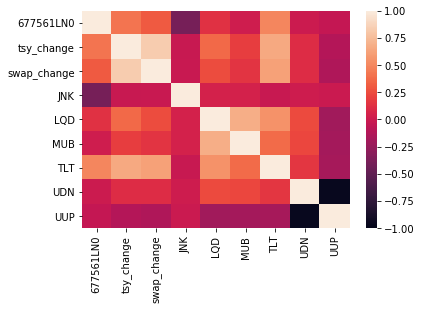

In [140]:
## heatmap
import seaborn as sns
sns.heatmap(hedge_corr, vmin=-1, vmax=1)

In [120]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    return hedge_corr.iloc[1,0]

In [121]:
tsy_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    tsy_corr.append(historical_corr_test(cusip))
tsy_corr

[-0.023468522297164538,
 -0.06994025619589567,
 -0.028131032092505594,
 -0.020758929155357687,
 0.41604887812481195,
 -0.04052588046257571,
 -0.022395209607663766,
 0.4110613525500944,
 -0.0006513105032610149,
 0.44185435008043683,
 0.04728293681447972,
 0.08557243880126834,
 -0.04040129415305014,
 0.08675011025798295,
 -0.039233961079190374,
 0.41446023081135897,
 0.5850407573288416,
 0.35426629291375855,
 0.4876217784333873,
 -0.02883305969471078,
 -0.1486360441511309,
 0.08759035903948362,
 0.01589308912453266,
 -0.058883540643586404,
 0.00672457308776882,
 0.009641282868220904,
 0.09926742343233126,
 0.11370978538864568,
 0.05793992369831087,
 -0.04288779358852415,
 0.048259958317662596,
 nan,
 0.054666089473304584,
 0.019645401854406386,
 0.0671842494338043,
 0.07826837950038695,
 0.04979410398497747,
 -0.11463814851258433,
 -0.11453359370214415,
 0.1161587776555138,
 0.008707112879706148,
 0.052026391010598,
 0.12178540333246388,
 0.06705150414022124,
 0.10171054035698572,
 0.080

In [122]:
print(tsy_corr)

[-0.023468522297164538, -0.06994025619589567, -0.028131032092505594, -0.020758929155357687, 0.41604887812481195, -0.04052588046257571, -0.022395209607663766, 0.4110613525500944, -0.0006513105032610149, 0.44185435008043683, 0.04728293681447972, 0.08557243880126834, -0.04040129415305014, 0.08675011025798295, -0.039233961079190374, 0.41446023081135897, 0.5850407573288416, 0.35426629291375855, 0.4876217784333873, -0.02883305969471078, -0.1486360441511309, 0.08759035903948362, 0.01589308912453266, -0.058883540643586404, 0.00672457308776882, 0.009641282868220904, 0.09926742343233126, 0.11370978538864568, 0.05793992369831087, -0.04288779358852415, 0.048259958317662596, nan, 0.054666089473304584, 0.019645401854406386, 0.0671842494338043, 0.07826837950038695, 0.04979410398497747, -0.11463814851258433, -0.11453359370214415, 0.1161587776555138, 0.008707112879706148, 0.052026391010598, 0.12178540333246388, 0.06705150414022124, 0.10171054035698572, 0.08063759653603043, 0.043686012968272, 0.10931930

In [123]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    tsy_corr_loc = hedge_corr.iloc[1,0]
    swap_corr_loc = hedge_corr.iloc[2,0]
    jnk_corr_loc = hedge_corr.iloc[3,0]
    lqd_corr_loc = hedge_corr.iloc[4,0]
    mub_corr_loc = hedge_corr.iloc[5,0]
    tlt_corr_loc = hedge_corr.iloc[6,0]
    udn_corr_loc = hedge_corr.iloc[7,0]
    uup_corr_loc = hedge_corr.iloc[8,0]
    #update the return to display the correlations to the specific hedges
    return swap_corr_loc

In [124]:
swap_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    swap_corr.append(historical_corr_test(cusip))
swap_corr
print(swap_corr)

[0.008124125734097414, -0.08153628601300804, -0.025268100447995295, -0.01491637088074826, 0.3110057690048767, -0.039556027448180556, -0.0295520101769186, 0.35858205910782165, -0.0029989083331374575, 0.3787577420793112, -0.031486657976997505, 0.13993519152145673, -0.02835709132455064, 0.00810587410410369, -0.06615348663720307, 0.3611494475307315, 0.4172023995844852, 0.29302642697017867, 0.40305907467468016, -0.052123048170619364, -0.21088742689384607, 0.03900572677409725, 0.08232035297238005, -0.01969417516905745, 0.06973523578322563, -0.12102860311349703, 0.04367140893940958, 0.10425342075707617, -0.010750657383526789, -0.0376498651235992, -0.010289881889430974, nan, -0.039330656926811515, 0.11310852839552438, 0.011961198067439633, 0.010040245393220106, -0.048074074898037125, -0.08787014265713232, -0.09153388061919729, 0.04550143530011058, -0.05422095714990065, 0.09904604139020382, 0.045936174272321446, 0.041499452187657215, 0.03347960279137833, 0.07579062911836087, 0.00881246151897409

In [125]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    tsy_corr_loc = hedge_corr.iloc[1,0]
    swap_corr_loc = hedge_corr.iloc[2,0]
    jnk_corr_loc = hedge_corr.iloc[3,0]
    lqd_corr_loc = hedge_corr.iloc[4,0]
    mub_corr_loc = hedge_corr.iloc[5,0]
    tlt_corr_loc = hedge_corr.iloc[6,0]
    udn_corr_loc = hedge_corr.iloc[7,0]
    uup_corr_loc = hedge_corr.iloc[8,0]
    #update the return to display the correlations to the specific hedges
    return lqd_corr_loc

In [126]:
lqd_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    lqd_corr.append(historical_corr_test(cusip))
lqd_corr
print(lqd_corr)

[0.13715410015046073, 0.10255111340969453, 0.17221225656132857, 0.2042011710344164, 0.13293086940457297, 0.1726273509452619, 0.1098892855430215, 0.31500836155250955, 0.17429808518370024, 0.30370029717292135, 0.4611231701407269, 0.06379865526848817, -0.012808134989751401, 0.4340067617613758, 0.3752824813175738, 0.3099403029712736, 0.056947909143757955, 0.3005655951166482, 0.453560544923884, 0.1524338687114648, 0.5101717061597925, 0.3756040172649297, 0.023834688354685638, 0.002068537628107349, -0.06195455427227444, 0.40342918580701204, 0.4620733283814791, 0.3722549269152347, 0.43021031988293024, 0.10786660062426918, 0.4530462078796896, nan, 0.4566544433998816, 0.5826118077277693, 0.42283798359843194, 0.43340017203679443, 0.3979350618404235, 0.37111459879296715, 0.3730898276077304, 0.3864543467771421, 0.4098571084836163, 0.2568843292819044, 0.37160188692494756, 0.34325538674659806, 0.42288417890356783, 0.328151690042507, 0.3949389115749171, 0.3161167048875338, 0.16911097225760083, -0.0068

In [127]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    tsy_corr_loc = hedge_corr.iloc[1,0]
    swap_corr_loc = hedge_corr.iloc[2,0]
    jnk_corr_loc = hedge_corr.iloc[3,0]
    lqd_corr_loc = hedge_corr.iloc[4,0]
    mub_corr_loc = hedge_corr.iloc[5,0]
    tlt_corr_loc = hedge_corr.iloc[6,0]
    udn_corr_loc = hedge_corr.iloc[7,0]
    uup_corr_loc = hedge_corr.iloc[8,0]
    #update the return to display the correlations to the specific hedges
    return mub_corr_loc

In [128]:
mub_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    mub_corr.append(historical_corr_test(cusip))
mub_corr
print(mub_corr)

[0.2022023314866174, 0.18618512791051486, 0.2577965191317667, 0.2922985037072636, 0.020029956244898943, 0.2476436141046092, 0.15465137387208336, 0.24273919359248433, 0.30232043332299224, 0.2529228592048347, 0.648459736475995, 0.28149071101889395, -0.006514535502547916, 0.5559689450234132, 0.6023308177668021, 0.19547701526632227, -0.044454507592147176, 0.18977475340155217, 0.39082652087005204, 0.19118499971662864, 0.5694611126771731, 0.564325183502022, 0.15415385573406504, 0.009663676101404402, 0.27602604817577725, 0.6177278476166436, 0.6003993668779904, 0.5347094733939852, 0.5743270737888614, 0.1991134449311603, 0.5923131025645645, nan, 0.66543963604383, 0.5400925511097112, 0.6483411070756759, 0.6394887983289439, 0.6055659240183966, 0.5193275385729172, 0.5191718936572667, 0.5491819857868366, 0.5247421955738443, 0.4845098086941197, 0.5048238864319468, 0.5005304519181397, 0.5961619285384323, 0.53993031330563, 0.5613880321501078, 0.5365191380221928, 0.18186792497728788, 0.0667100213363763

In [129]:
def historical_corr_test(cusip):
    # find maturity of chosen muni bond and convert to datetime
    bond_mty = bondescr_df.loc[cusip,'Maturity Date']
    bond_mty = dt.datetime.strptime(bond_mty, '%m/%d/%Y')
    bond_mty

    # create series with bond years to maturity for lookup in dataframes
    # relativedelta function: https://dateutil.readthedocs.io/en/stable/relativedelta.html
    ## make output for years more exact by looking at days/360 and rounding?
    mty_years = []
    for return_date in bonds_daily_returns.index:
        difference = relativedelta(bond_mty, return_date)
        mty_years.append(difference.years)
    #len(mty_years)

    # reference closest maturity in tsy and swap df
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    tsy_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in USTREASURY_data_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        tsy_index.append(min_item)

    swap_index = []
    for item in mty_years:
        min_item = ' '
        min_value = 0
        for col in swaps_daily_returns.columns:
            if min_item == ' ':
                min_item = col
                min_value = abs(col - int(item))
            elif abs(col - int(item)) < min_value:
                min_item = col
                min_value = abs(col - int(item))
        swap_index.append(min_item)
    #len(swap_index)
    #len(tsy_index)

    # create new dataframe to combine items
    # USTREASURY_data_daily_returns, swaps_daily_returns, mty_years
    joined_df = pd.DataFrame(bonds_daily_returns[cusip])
    joined_df['tsy_index'] = tsy_index
    joined_df['swap_index'] = swap_index
    
    joined_df = pd.merge(joined_df, USTREASURY_data_daily_returns, left_index=True, right_index=True)

    tsy_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['tsy_index'][indx]]
        tsy_change.append(change)
    joined_df['tsy_change'] = tsy_change
    tsy_col_drop = ['tsy_index',1,2,3,5,7,10,20,30]
    joined_df.drop(columns=tsy_col_drop,inplace=True)

    joined_df = pd.merge(joined_df, swaps_daily_returns, left_index=True, right_index=True)

    swap_change = []
    for indx in joined_df.index:
        change = joined_df.loc[indx, joined_df['swap_index'][indx]]
        swap_change.append(change)
    joined_df['swap_change'] = swap_change
    swap_col_drop = ['swap_index',1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
    joined_df.drop(columns=swap_col_drop,inplace=True)

    ##concat separate dataframes (muni etf, treasury etf)
    #ETF_daily_returns_df
    joined_df = pd.merge(joined_df, ETF_daily_returns_df, left_index=True, right_index=True)
    #joined_df.head()

    ## calculate standard deviation
    hedge_corr = joined_df.corr()
    tsy_corr_loc = hedge_corr.iloc[1,0]
    swap_corr_loc = hedge_corr.iloc[2,0]
    jnk_corr_loc = hedge_corr.iloc[3,0]
    lqd_corr_loc = hedge_corr.iloc[4,0]
    mub_corr_loc = hedge_corr.iloc[5,0]
    tlt_corr_loc = hedge_corr.iloc[6,0]
    udn_corr_loc = hedge_corr.iloc[7,0]
    uup_corr_loc = hedge_corr.iloc[8,0]
    #update the return to display the correlations to the specific hedges
    return tlt_corr_loc

In [130]:
tlt_corr = []
for item in bonds_daily_returns.columns:
    cusip = item
    tlt_corr.append(historical_corr_test(cusip))
tlt_corr
print(tlt_corr)

[0.12292000381881635, 0.054531083011165826, 0.10472771491718957, 0.15189871173597608, 0.49573505842666593, 0.11220509765930953, 0.0900657890317165, 0.6107249897852458, 0.13470909062590655, 0.6371236230253732, 0.0993186392130942, 0.18238414366335193, 0.003430494194631434, 0.10415380619410186, -0.05321053613969361, 0.6266345268725438, 0.6990933845733314, 0.5952526104685254, 0.767050102606221, 0.08721256949747562, -0.007162780734991862, 0.20452680866435158, 0.10740874438927792, 0.04245637736635568, 0.17567222043027747, -0.042380192591632115, 0.1858308133861539, 0.2269096842516111, 0.11803345758794877, 0.20480920422626017, 0.0915439140321715, nan, 0.058985638264474, 0.5570850420740638, 0.18962292033843495, 0.09443882447114928, 0.01580860937113285, -0.11756853677983345, -0.11994599093517729, 0.2267102035215799, 0.0247874919929632, 0.1674470473070972, 0.22117051400113788, 0.10680332669494971, 0.19691548478910903, 0.19540732944673536, 0.17447239131682146, 0.2224758562618048, 0.519951455650207

In [131]:
len(tsy_corr)

816

In [132]:
len(swap_corr)

816

In [133]:
len(lqd_corr)

816

In [134]:
len(mub_corr)

816

In [135]:
len(tlt_corr)

816

In [168]:
muni_bond_correlation_df = pd.DataFrame(
    {'CUSIP': bonds_daily_returns.columns,
     'Treasury Correlation': tsy_corr,
     'Swap Correlation': swap_corr,
     'LQD ETF Correlation': lqd_corr,
     'MUB ETF Correlation': mub_corr,
     'TLT ETF Correlation': tlt_corr
    })

In [169]:
muni_bond_correlation_df.set_index('CUSIP',inplace=True)

In [170]:
muni_bond_correlation_df.head()

,Treasury Correlation,Swap Correlation,LQD ETF Correlation,MUB ETF Correlation,TLT ETF Correlation
CUSIP,,,,,
57583R5Q4,-0.023469,0.008124,0.137154,0.202202,0.122920
751100HG6,-0.069940,-0.081536,0.102551,0.186185,0.054531
93978HBK0,-0.028131,-0.025268,0.172212,0.257797,0.104728
34153PC55,-0.020759,-0.014916,0.204201,0.292299,0.151899
677561LN0,0.416049,0.311006,0.132931,0.020030,0.495735


In [196]:
bondescr_df.head()

,Security,Coupon,Next Call Date,Maturity Date,Bloomberg Composite Rating,U.S States
CUSIP,,,,,,
546417DJ2,LOUISIANA ST -B -REF,5.0,NaN,11/15/2020,AA-,LA
59259YQW2,MET TRANS-D-REF,5.0,NaN,11/15/2020,BBB+,NY
59261AJX6,MET TRANSPRTN AUTH NY,5.0,NaN,11/15/2020,BBB+,NY
89602NZX5,TRIBORO BRDG-B,5.0,NaN,11/15/2020,AA-,NY
13063CHQ6,CALIFORNIA ST-VARIOUS,5.0,NaN,12/01/2020,AA-,CA


In [172]:
muni_bond_characteristics_correlations_df = pd.merge(bondescr_df, muni_bond_correlation_df, left_index=True, right_index=True)

In [174]:
muni_bond_characteristics_correlations_df.dropna(subset=["Treasury Correlation"],inplace=True)
muni_bond_characteristics_correlations_df.describe()

,Coupon,Treasury Correlation,Swap Correlation,LQD ETF Correlation,MUB ETF Correlation,TLT ETF Correlation
count,812.000000,812.000000,812.000000,812.000000,812.000000,812.000000
mean,4.479064,0.087492,0.054004,0.282419,0.385256,0.172005
std,0.857434,0.187325,0.172877,0.166117,0.209231,0.234057
min,2.570000,-1.000000,-0.398898,-1.000000,-1.000000,-1.000000
25%,4.000000,-0.017830,-0.039372,0.163549,0.223813,0.032594
50%,5.000000,0.028647,-0.000602,0.314290,0.419963,0.100384
75%,5.000000,0.094066,0.068950,0.401622,0.561598,0.210272
max,7.810000,1.000000,1.000000,1.000000,1.000000,1.000000


In [175]:
muni_bond_characteristics_correlations_df.head()

,Security,Coupon,Next Call Date,Maturity Date,Bloomberg Composite Rating,U.S States,Treasury Correlation,Swap Correlation,LQD ETF Correlation,MUB ETF Correlation,TLT ETF Correlation
CUSIP,,,,,,,,,,,
645916Z59,NJ ECON-REF-K-SCH FAC,5.25,NaN,12/15/2020,BBB+,NJ,-0.010873,-0.013965,0.068674,0.179393,0.073709
6461355Q2,NJ TRN-B-TRN SYS,5.50,NaN,12/15/2020,BBB+,NJ,-0.041956,-0.039644,-0.014781,0.112518,0.049319
646136DY4,NJ TRN FD SER A,5.25,NaN,12/15/2020,BBB+,NJ,-0.038288,-0.032066,0.092403,0.183315,0.093155
452152G21,ILLINOIS ST-REF,5.00,NaN,02/01/2021,BBB-,IL,0.039164,-0.004561,0.061425,0.059925,-0.048105
880443DZ6,TN ENERGY,5.00,NaN,02/01/2021,BBB+,TN,-0.099722,-0.095939,0.070942,0.134891,0.045558


In [197]:
# Create hvplot scatter plot showing muni correlations to each hedging instrument
# treasury correlation
muni_bond_characteristics_correlations_df.hvplot.scatter(x='Maturity Date',y='Treasury Correlation', by='Bloomberg Composite Rating', rot=90, height=600, width=1000, title='Muni Bond Correlations to Treasuries')

:NdOverlay   [Bloomberg Composite Rating]
   :Scatter   [Maturity Date]   (Treasury Correlation)

In [198]:
#swap correlation

muni_bond_characteristics_correlations_df.hvplot.scatter(x='Maturity Date',y='Swap Correlation', by='Bloomberg Composite Rating', rot=90, height=600, width=1000, title='Muni Bond Correlations to LIBOR Swaps')

:NdOverlay   [Bloomberg Composite Rating]
   :Scatter   [Maturity Date]   (Swap Correlation)

In [201]:
#LQD Correlation
muni_bond_characteristics_correlations_df.hvplot.scatter(x='Maturity Date',y='LQD ETF Correlation', by='Bloomberg Composite Rating', rot=90, height=600, width=1000, title='Muni Bond Correlations to LQD - Investment Grade Corporate Bond ETF')

:NdOverlay   [Bloomberg Composite Rating]
   :Scatter   [Maturity Date]   (LQD ETF Correlation)

In [202]:
#MUB Correlation

muni_bond_characteristics_correlations_df.hvplot.scatter(x='Maturity Date',y='MUB ETF Correlation', by='Bloomberg Composite Rating', rot=90, height=600, width=1000, title='Muni Bond Correlations to MUB - Municipal Bond ETF')

:NdOverlay   [Bloomberg Composite Rating]
   :Scatter   [Maturity Date]   (MUB ETF Correlation)

In [200]:
#TLT Correlation

muni_bond_characteristics_correlations_df.hvplot.scatter(x='Maturity Date',y='TLT ETF Correlation', by='Bloomberg Composite Rating', rot=90, height=600, width=1000, title='Muni Bond Correlations to TLT - Treasury Bond ETF')

:NdOverlay   [Bloomberg Composite Rating]
   :Scatter   [Maturity Date]   (TLT ETF Correlation)

In [ ]:
#mapbox visualization of muni bonds - use bondescr_df
#pull in latitude/longitude csv for center of state - from Adrienne
#phil - try and get issue size for each cusip so we can visualize issue amount by state
#at the very least we will have a mapbox visualization of the 6711 bonds broken up by state